In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


In [6]:
test.head(5)

customer_ID  shopping_pt  record_type  day   time state  location  \
0     10000001            1            0    1  12:35    OK   10002.0   
1     10000001            2            0    1  12:36    OK   10002.0   
2     10000002            1            0    4  12:19    PA   10003.0   
3     10000002            2            0    4  12:21    PA   10003.0   
4     10000003            1            0    3  17:12    AR   10004.0   

   group_size  homeowner  car_age  ... C_previous  duration_previous  A  B  C  \
0           1          0        9  ...        3.0                9.0  0  0  1   
1           1          0        9  ...        3.0                9.0  2  1  1   
2           1          1        7  ...        2.0               15.0  2  0  2   
3           1          1        7  ...        2.0               15.0  2  0  2   
4           1          0        4  ...        3.0                1.0  1  0  1   

   D  E  F  G  cost  
0  1  0  0  4   543  
1  3  1  3  2   611  
2  3  1  2  2   691  
3  3  1  2  2   695  
4  1  0  2  2   628  

[5 rows x 25 columns]

### Baseline Submission

In [5]:
test=pd.read_csv("test_v2.csv")
test.head(5)

print(test.size)
result=test.sort_values(by=['day','time']).groupby('customer_ID').tail(1)
result=result[['customer_ID','A','B','C','D','E','F','G']]
result.head()

for C in result.columns:
    result[C]=result[C].astype(str)
result.head()
result['plan']=result['A'] + result['B']+ result['C']+ result['D']+ result['E']+ result['F']+ result['G']
result=result[['customer_ID','plan']]
result.head()

result.to_csv(r'baseline.csv')

4971400


In [7]:
pd.read_csv("baseline.csv")

Unnamed: 0  customer_ID     plan
0           23434     10017709  2033024
1           11337     10008537  1022002
2          106001     10081351    22002
3           21837     10016543  1033121
4          164138     10125740  1123123
...           ...          ...      ...
55711      144934     10111031  1113111
55712          31     10000011  1033022
55713        8035     10006040  1011021
55714      163110     10124951    11004
55715      170745     10130803  1043114

[55716 rows x 3 columns]

### Data Preparation

In [177]:
train=pd.read_csv("C:/Users/karth/Documents/Kaggle/Purchase Prediction/train.csv")
test=pd.read_csv("C:/Users/karth/Documents/Kaggle/Purchase Prediction/test_v2.csv")
print(train.shape)
print(test.shape)

frames = [train, test]
my_data = pd.concat(frames,keys=['train', 'test'])
print(my_data.shape)

(665249, 25)
(198856, 25)
(864105, 25)


In [178]:
my_data['location'] = my_data['location'].fillna(0)
my_data['C_previous'] = my_data['C_previous'].fillna(99)
my_data['duration_previous'] = my_data['duration_previous'].fillna(99)
my_data['car_value'] = my_data['car_value'].fillna(99)

my_data= my_data.dropna(axis='columns')
my_data.isnull().sum(axis = 0)

customer_ID          0
shopping_pt          0
record_type          0
day                  0
time                 0
state                0
location             0
group_size           0
homeowner            0
car_age              0
car_value            0
age_oldest           0
age_youngest         0
married_couple       0
C_previous           0
duration_previous    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
cost                 0
dtype: int64

In [179]:
def one_hot(df, cols):
    for col in cols:
        df[col] = df[col].astype('category')
    df=pd.concat([df,pd.get_dummies(df[cols])], axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df
        
def time_convert(df):
    df['time'] = df['time'].apply(lambda x: (int(x[:2]) * 60) + int(x[3:]))
    df['time_sin'] = np.sin((df['time'] * np.pi) / 1800)
    df['time_cos'] = np.cos((df['time'] * np.pi) / 1800)
    df = df.drop(['time'], axis=1)
    return df

In [180]:
cat_cols = ['shopping_pt','day', 'state',
       'group_size', 'homeowner', 'car_age','car_value', 'age_oldest', 'age_youngest',
       'married_couple','C_previous','duration_previous','A','B','C','D','E','F','G']
my_data = one_hot(my_data,cat_cols)
my_data = time_convert(my_data)

In [187]:
#Split data back in to train & Test

my_train=my_data.loc['train']
my_test=my_data.loc['test']
print(my_train.shape)
print(my_test.shape)

(665249, 310)
(198856, 310)


In [188]:
my_train.columns

Index(['customer_ID', 'record_type', 'location', 'cost', 'shopping_pt_1',
       'shopping_pt_2', 'shopping_pt_3', 'shopping_pt_4', 'shopping_pt_5',
       'shopping_pt_6',
       ...
       'F_0', 'F_1', 'F_2', 'F_3', 'G_1', 'G_2', 'G_3', 'G_4', 'time_sin',
       'time_cos'],
      dtype='object', length=310)

In [189]:
#splitting my train data in to train & validation
y = my_train['record_type']
X = my_train
X.drop(['record_type','customer_ID'], axis=1, inplace=True)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)
print("Training data size", X_train.shape)
print("validation data size", X_val.shape)

C:\Users\karth\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Training data size (532199, 308)
validation data size (133050, 308)


In [190]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_val=logreg.predict(X_val)
metrics.confusion_matrix(y_val,y_pred)

array([[112034,   1460],
       [ 18140,   1416]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val, y_pred))

(0, 1)

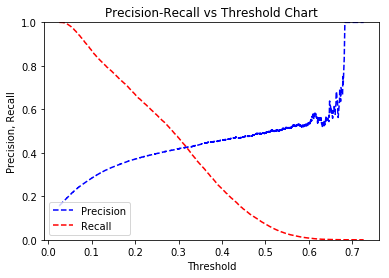

In [149]:
### Predict test_y values and probabilities based on fitted logistic 

y_pred_val=logreg.predict(X_val)
y_pred_prob_val=logreg.predict_proba(X_val) 

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob_val[:,1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [150]:
#Changing Threshold of Logistic regression
mythreshold=0.1
y_pred_val = (y_pred_prob_val[:,1]>= mythreshold).astype(int)
print(accuracy_score(y_val, y_pred_val))

0.6574069898534386


In [151]:
#Buidling model on entire data and predicting on Test data
logreg = LogisticRegression()
logreg.fit(X, y)

my_test_copy=my_test.drop(['record_type','customer_ID'], axis=1)
test_pred=logreg.predict_proba(my_test_copy)

In [152]:
y_pred_test = (test_pred[:,1]>= mythreshold).astype(int)

print(sum(y_pred_test))
print(test.customer_ID.unique().size)

37068
55716


In [156]:
test.columns

Index(['customer_ID', 'shopping_pt', 'record_type', 'day', 'time', 'state',
       'location', 'group_size', 'homeowner', 'car_age', 'car_value',
       'risk_factor', 'age_oldest', 'age_youngest', 'married_couple',
       'C_previous', 'duration_previous', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'cost'],
      dtype='object')

In [155]:

#Getting the Policy Matrix - with all possible options

A = [0, 1, 2]
B = [0, 1]
C = [1, 2, 3, 4]
D = [1, 2, 3]
E = [0, 1]
F = [0, 1, 2, 3]
G = [1, 2, 3, 4]

#Cross product of all policy combinations
index = pd.MultiIndex.from_product([A, B, C, D, E, F, G], names = ["A", "B", "C", "D", "E", "F", "G"])
policy_matrix=pd.DataFrame(index = index).reset_index()
print(policy_matrix.shape)

cols=['A','B','C','D','E','F','G']
# policy_matrix = one_hot(policy_matrix,cols)


(2304, 7)


In [163]:
my_test_temp=test[['customer_ID', 'shopping_pt']]
my_test_new=my_test.merge(my_test_temp, left_on='customer_ID', right_on='customer_ID', how='left')
my_test_new=my_test_new.loc[my_test_new.groupby('customer_ID').shopping_pt.idxmax()]

In [170]:
# my_test_new

In [169]:
# my_test_new['_tmpkey'] = 1
# policy_matrix['_tmpkey'] = 1
    
# res = pd.merge(my_test_new, policy_matrix, on='_tmpkey').drop('_tmpkey', axis=1)
# res.index = pd.MultiIndex.from_product((my_test_new.index, policy_matrix.index))

# my_test_new.drop('_tmpkey', axis=1, inplace=True)
# policy_matrix.drop('_tmpkey', axis=1, inplace=True)


In [171]:
train_policy= train[['A','B','C','D','E','F','G']]
corr = train_policy.corr()
corr.style.background_gradient(cmap='coolwarm')